In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tic_env import TictactoeEnv, OptimalPlayer
from utils import play_game, Metric
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm_notebook
import itertools
import pickle

# Q-learning

## Learning from experts

In [2]:
#################################################################################
#-------------------------------------------- Helpers
def get_hash(state:np.array)->str:
    
    return str(state.flatten(order='C'))


def get_available_positions(state:np.array):
      
    flatten_array = state.flatten(order='C')
    indices = np.argwhere(np.abs(flatten_array)<1).T
    
    return indices.flatten()

def get_best_action(availables_positions:np.array,array_of_q_values:np.array):
    
    A = np.argmax(array_of_q_values,axis=1)[0]
    #print(availables_positions)
    
    if  A in availables_positions :
        return A.item()
    
    else :
        A = availables_positions[0]
        for i in availables_positions :
            if array_of_q_values[:,i]>array_of_q_values[:,A]:
                A = i
        return A.item()

def get_action(epsilon,current_state,current_state_hash,q_table):
    
    availables_positions = get_available_positions(current_state)
    rnd = np.random.uniform(0,1)
                
    if rnd > epsilon :
        A = get_best_action(availables_positions,q_table[current_state_hash]) # best move among possible moves        
    else:
        np.random.shuffle(availables_positions) # shuffle
        A = availables_positions[0] # take first
        A = A.item()
    
    return A
    

def get_max_Q(q_table:dict,state:np.array):
        
    hash_ = get_hash(state)
    max_q = 0.
    
    if hash_ in q_table.keys():
        max_q = np.max(q_table[hash_],axis=1)
        
    return max_q
    
#---------------------------------------------------
#################################################################################
def update_player(q_table,current_state,next_state,A,alpha,reward,gamma):
    
    current_state_hash = get_hash(current_state)
    
    if next_state is not None :
        #----- Update q_table
        array_of_q_values = q_table[current_state_hash]
        q_value = array_of_q_values[:,A]
        updated_q_value = q_value + alpha*(reward + gamma*get_max_Q(q_table,next_state) - q_value)
        array_of_q_values[:,A] = updated_q_value # update Q(S,A)
        q_table[current_state_hash] = array_of_q_values # store updated Q(S,A)
    
    else:
        #----- Update q_table when there is no next_state
        array_of_q_values = q_table[current_state_hash]
        q_value = array_of_q_values[:,A]
        updated_q_value = q_value + alpha*(reward + gamma*0.0 - q_value)
        array_of_q_values[:,A] = updated_q_value # update Q(S,A)
        q_table[current_state_hash] = array_of_q_values # store updated Q(S,A)
    
    return q_table


class agent:
    
    def __init__(self,q_table):
        self.q_table = q_table
        
    def act(self,grid):
        
        grid_hash = get_hash(grid)
        availables_positions = get_available_positions(grid)
        
        #-- for states in the q_table
        if grid_hash in self.q_table.keys():
            A = get_best_action(availables_positions,self.q_table[grid_hash])
        
        #-- For any other state not discovered, any available action can be taken
        else :
            np.random.shuffle(availables_positions)
            A = availables_positions[0].item()
            
        return A

def test_policy(eps_optimalplayer,q_table,verbose=False):
    
    env = TictactoeEnv() # environment
    agent_player = agent(q_table) # agent
    
    #-- Holders 
    wins_count = dict()
    wins_count['optimal_player']=0
    wins_count['agent']=0
    wins_count['draw']=0 
    players = dict()
    players[None] = 'draw'
    turns = np.array(['X','O'])
    
    for episode in range(500):
        
        env.reset()
        np.random.seed(episode) 
        
        if episode < 250 :
            player_opt = OptimalPlayer(epsilon=eps_optimalplayer,player=turns[1])
            players[turns[0]]=(player_opt,'optimal_player')
            players[turns[1]]=(agent_player,'agent')
        else:
            player_opt = OptimalPlayer(epsilon=eps_optimalplayer,player=turns[0])
            players[turns[0]]=(agent_player,'agent')
            players[turns[1]]=(player_opt,'optimal_player')
        
        for j in range(9):    
            
            #-- Get turn
            turn = env.current_player
            
            #-- observe grid
            grid,end,_ = env.observe() 
            
            #-- Play
            current_player, _ = players[turn]
            move = current_player.act(grid) 
            env.step(move,print_grid=False)
        
            #-- Chek that the game has finished
            if env.end :
                if env.winner is not None :
                    _,winner = players[env.winner]
                    wins_count[winner] = wins_count[winner] + 1
                else :
                    wins_count['draw'] = wins_count['draw'] + 1
                
                break
    
    M = (wins_count['agent']-wins_count['optimal_player'])/500
    
    if verbose :
        string ="M_rand"
        if eps_optimalplayer < 1:
            string = "M_opt"    
        print(string+" : ",M)
        print(wins_count,'\n')

    
    return M


def q_learning(epsilon,num_episodes:int,env:TictactoeEnv,path_save:str,eps_opt=0.5,alpha=0.05,gamma=0.99,render=False,test=False):
    
    q_table = dict()
    turns = np.array(['X','O'])
    
    #-- Holder 
    wins_count = dict()
    wins_count['optimal_player']=0
    wins_count['agent']=0
    wins_count['draw']=0
    players = dict()
    players[None] = 'draw'
    M_opts = list()
    M_rands = list()
    accumulate_reward = 0
    agent_mean_rewards = [0]*int(num_episodes//250)
    
    for episode in range(1,num_episodes+1):
        
        if episode % 250 == 0 :
            agent_mean_rewards[int(episode//250)-1] = accumulate_reward/250
            accumulate_reward = 0 # reset
            if episode % 5000 == 0 :
                print(f"\nEpisode : {episode}")
                print(wins_count)
            if test:
                M_opt = test_policy(0,q_table,verbose=False)
                M_rand = test_policy(1,q_table,verbose=False)
                M_opts.append(M_opt)
                M_rands.append(M_rand)
                
        env.reset()
        turns = turns[np.random.permutation(2)]
        player_opt = OptimalPlayer(epsilon=eps_opt,player=turns[0])
        agent_learner = turns[1]
        
        players[turns[0]]='optimal_player'
        players[turns[1]]='agent'
        
        current_state = None
        next_state = None
        A = None
        
        for j in range(9) : # The game takes at most 9 steps to finish

            #-- Optimal player plays 
            if env.current_player == turns[0]  :
                grid,end,_ = env.observe() #-- observe grid
                move = player_opt.act(grid) #-- get move
                env.step(move,print_grid=False) # optimal player takes a move
                
                #-- update agent q_table after optimal player takes a step
                if current_state is not None :
                    reward = env.reward(agent_learner)
                    q_table = update_player(q_table,current_state,env.observe()[0],A,alpha,reward,gamma) # the next state where agent can play is after optimal has played

            #-- agent plays
            else:   
                
                #-- Learning agent updates q_table
                current_state = env.observe()[0]
                current_state_hash = get_hash(current_state) 
                
                # Add current_state in q_table if applicable
                if not(current_state_hash in q_table.keys()): 
                    q_table[current_state_hash]=np.zeros((1,9))
                            
                #----- Choose action A with epsilon greedy
                A = get_action(epsilon(episode), current_state, current_state_hash,q_table)
                
                #----- Take action A & Observe reward
                next_state,end,_ = env.step(A,print_grid=False)
                reward = env.reward(agent_learner)
                if reward > 0:  
                    #----- Update q_table when agent wins -> No next_state
                    q_table = update_player(q_table,current_state,None,A,alpha,reward,gamma)
                    
                #----- Update q_table
                #q_table = update_player(q_table,current_state,next_state,A,alpha,reward,gamma)

            #-- Chek that the game hasn't finished
            if env.end :
                if env.winner is not None :
                    winner = players[env.winner]
                    wins_count[winner] = wins_count[winner] + 1
                else :
                    wins_count['draw'] = wins_count['draw'] + 1

                if render : 
                    print(f"Episode {episode} ; Winner is {winner}.")
                    env.render()
                    
                #-- Updating Q-value when agent looses
                #if env.reward(agent_learner) == -1:  
                    #----- Update q_table
                    #q_table = update_player(q_table,current_state,env.observe()[0],A,alpha,-1,gamma)
                    
                #-- accumulate rewards
                accumulate_reward += env.reward(agent_learner)
                    
                break
            
        #print(episode,env.winner)
        
    #--save
    if path_save is not None:
        with open(path_save,'wb') as file:
            pickle.dump(q_table, file)
    
    return q_table,wins_count,agent_mean_rewards,M_opts,M_rands



Episode : 5000
{'optimal_player': 1465, 'agent': 2188, 'draw': 1346}

Episode : 10000
{'optimal_player': 2697, 'agent': 4480, 'draw': 2822}

Episode : 15000
{'optimal_player': 3879, 'agent': 6822, 'draw': 4298}

Episode : 20000
{'optimal_player': 5043, 'agent': 9203, 'draw': 5753}


Text(0.5, 1.0, 'Average rewards with Epsilon 0.1')

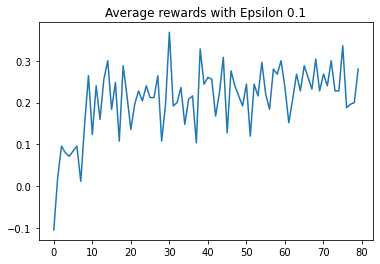

In [3]:
#-- Question 1
eps_1=lambda x : 0.1
path = './20k_eps_01-v2.pickle'
env = TictactoeEnv()
q_table,wins_count,agent_mean_rewards,M_opts,M_rands = q_learning(epsilon=eps_1,num_episodes=int(20e3),env=env,path_save=path,alpha=0.05,gamma=0.99,render=False,test=False)
plt.plot(agent_mean_rewards)
plt.title(f'Average rewards with Epsilon {eps_1(0)}')


Running for 1

Episode : 5000
{'optimal_player': 1494, 'agent': 2147, 'draw': 1358}

Episode : 10000
{'optimal_player': 2689, 'agent': 4547, 'draw': 2763}

Episode : 15000
{'optimal_player': 3849, 'agent': 7037, 'draw': 4113}

Episode : 20000
{'optimal_player': 4989, 'agent': 9515, 'draw': 5495}

Running for 10000.0

Episode : 5000
{'optimal_player': 2939, 'agent': 1168, 'draw': 892}

Episode : 10000
{'optimal_player': 4389, 'agent': 3322, 'draw': 2288}

Episode : 15000
{'optimal_player': 5317, 'agent': 5870, 'draw': 3812}

Episode : 20000
{'optimal_player': 6163, 'agent': 8471, 'draw': 5365}

Running for 20000.0

Episode : 5000
{'optimal_player': 3182, 'agent': 1033, 'draw': 784}

Episode : 10000
{'optimal_player': 5646, 'agent': 2536, 'draw': 1817}

Episode : 15000
{'optimal_player': 7363, 'agent': 4655, 'draw': 2981}

Episode : 20000
{'optimal_player': 8394, 'agent': 7293, 'draw': 4312}

Running for 30000.0

Episode : 5000
{'optimal_player': 3169, 'agent': 1062, 'draw': 768}

Episo

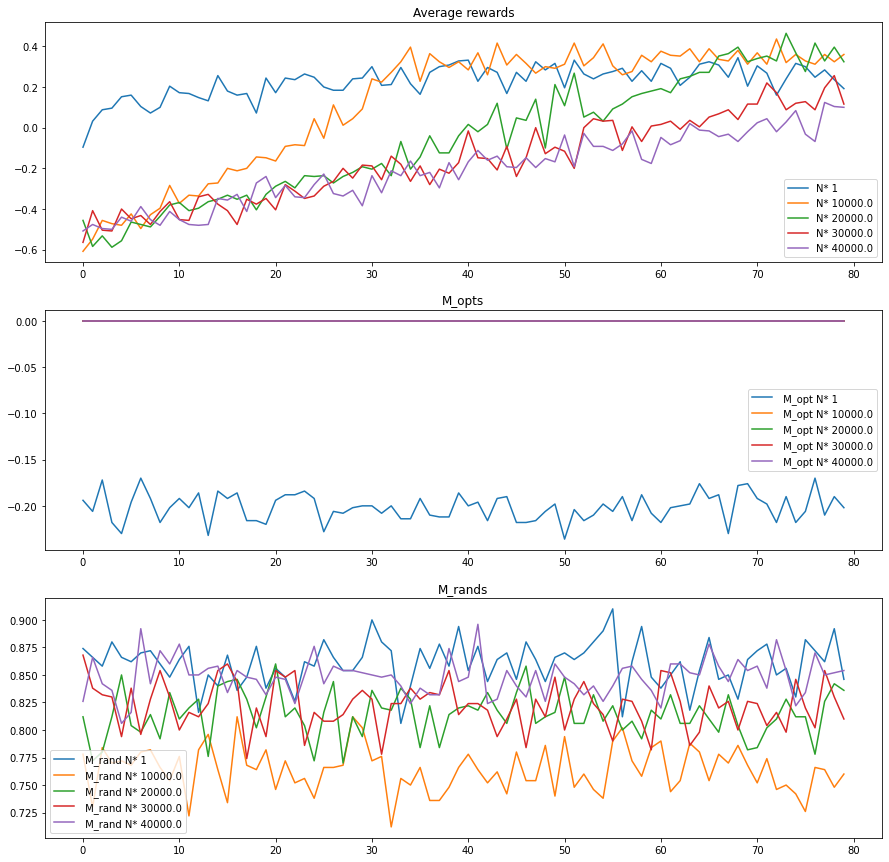

In [38]:
#-- Question 2 and 3
eps_min=0.1
eps_max=0.8
fig,axs = plt.subplots(3,1,figsize=(15,15))
env = TictactoeEnv()
test=True # set to True to compute M_opts and M_rands
means = dict() # --> {N_star : [mean M_opt,mean M_rand]}
for N_star in [1,10e3,20e3,30e3,40e3]:
    print(f"\nRunning for {N_star}")
    eps_2=lambda x : max([eps_min,eps_max*(1-x/N_star)])
    q_table,wins_count,agent_mean_rewards,M_opts,M_rands = q_learning(epsilon=eps_2,num_episodes=int(20e3),
                                                                      env=env,path_save='./20k_decrease.pickle',
                                                                      alpha=0.05,gamma=0.99,render=False,test=test)
    axs[0].plot(agent_mean_rewards,label=f'N* {N_star}')
    axs[1].plot(M_opts,label=f' M_opt N* {N_star}')
    axs[2].plot(M_rands,label=f' M_rand N* {N_star}')
    
    #-- Store mean values
    means[N_star] = [sum(M_rands)/len(M_rands),sum(M_opts)/len(M_opts)]
    
axs[1].set_title('M_opts')
axs[0].set_title('Average rewards')
axs[2].set_title('M_rands')
axs[2].legend()
axs[1].legend()
axs[0].legend()
plt.show()

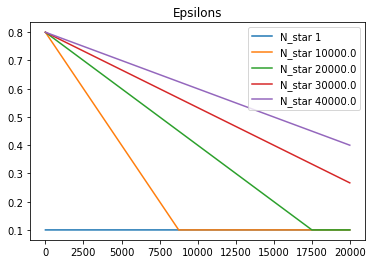

In [31]:
#-- Additional : plotting epsilon profiles
eps_min=0.1
eps_max=0.8
for N_star in [1,10e3,20e3,30e3,40e3]:
    eps_2=lambda x : max([eps_min,eps_max*(1-x/N_star)])
    plt.plot(list(map(eps_2,range(1,20000+1))),label=f'N_star {N_star}')
plt.title("Epsilons")
plt.legend()
plt.show()

In [39]:
#-- Q.4 Select best N_star
for key,val in means.items():
    print(key," --> ",val)

1  -->  [0.8604999999999997, -0.20170000000000005]
10000.0  -->  [0.7640499999999999, 0.0]
20000.0  -->  [0.8144499999999999, 0.0]
30000.0  -->  [0.8219749999999999, 0.0]
40000.0  -->  [0.8479749999999999, 0.0]



Running for esp_opt=0 -->

Episode : 5000
{'optimal_player': 4230, 'agent': 0, 'draw': 769}

Episode : 10000
{'optimal_player': 8100, 'agent': 0, 'draw': 1899}

Episode : 15000
{'optimal_player': 11720, 'agent': 0, 'draw': 3279}

Episode : 20000
{'optimal_player': 15079, 'agent': 0, 'draw': 4920}

Running for esp_opt=0.25 -->

Episode : 5000
{'optimal_player': 3716, 'agent': 447, 'draw': 836}

Episode : 10000
{'optimal_player': 7039, 'agent': 1066, 'draw': 1894}

Episode : 15000
{'optimal_player': 10110, 'agent': 1783, 'draw': 3106}

Episode : 20000
{'optimal_player': 12837, 'agent': 2715, 'draw': 4447}

Running for esp_opt=0.5 -->

Episode : 5000
{'optimal_player': 3136, 'agent': 1070, 'draw': 793}

Episode : 10000
{'optimal_player': 5845, 'agent': 2518, 'draw': 1636}

Episode : 15000
{'optimal_player': 8200, 'agent': 4151, 'draw': 2648}

Episode : 20000
{'optimal_player': 10252, 'agent': 6022, 'draw': 3725}

Running for esp_opt=0.75 -->

Episode : 5000
{'optimal_player': 2687, 'agen

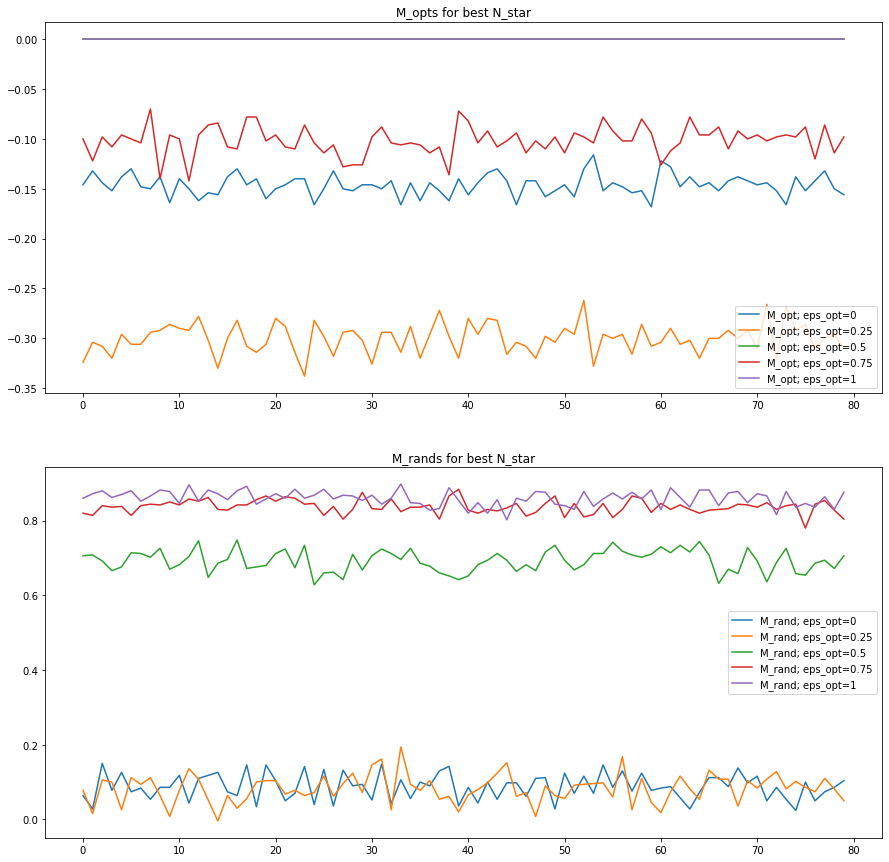

In [36]:
#-- Q.4
env = TictactoeEnv()
test=True
N_star = 40e3 # best is n_star = 40e3
Mopts_list = list()
Mrand_list = list()
fig,axs = plt.subplots(2,1,figsize=(15,15))
print("Best N_star is : ",N_star)
for eps in [0,0.25,0.5,0.75,1]:
    print(f'\nRunning for esp_opt={eps} -->')
    eps_2=lambda x : max([eps_min,eps_max*(1-x/N_star)])
    q_table,wins_count,agent_mean_rewards,M_opts,M_rands = q_learning(epsilon=eps_2,eps_opt=eps,num_episodes=int(20e3),env=env,path_save='./20k_Q4.pickle',alpha=0.05,gamma=0.99,render=False,test=test)
    axs[0].plot(M_opts,label=f'M_opt; eps_opt={eps}')
    axs[1].plot(M_rands,label=f'M_rand; eps_opt={eps}')
    Mopts_list.append(M_opts)
    Mrand_list.append(M_rands)

axs[0].set_title('M_opts for best N_star')
axs[1].set_title('M_rands for best N_star')
axs[0].legend()
axs[1].legend()
plt.show()

In [37]:
#-- Q.5
print(f"The maximum M_opt is {max([max(a) for a in Mopts_list])}  \nthe maximum M_rand is {max([max(a) for a in Mrand_list])}")

The maximum M_opt is 0.0  
the maximum M_rand is 0.898


In [ ]:
#-- Q.6
"""
    Provide Answer here!!

"""

## Learning by self-practice

In [3]:
#define state table with all possible combinations.
boards = []
for i in range(0 , 19683) : 
    c=i
    temp_boards = []
    for ii in range(0 , 9) : 
        temp_boards.append(c % 3)
        c = c // 3
    boards.append(temp_boards)
boards=np.array(boards)
boards[boards == 0]= -1
boards[boards == 2]= 0
boards=boards.tolist()

In [3]:

def dec_exp(n, n_, e_min=.1, e_max=.8):
    #helper function for decreasing exploration rate.
    return max(e_min,e_max*(1- n/n_))


def get_state(grid,player,boards=boards):
    #helper function to get the state from the grid. the sign changes for each player.
    #the state hash is the index of the board in the boards table
    sign={'X':1,'O':-1}
    return boards.index((sign[player.player]*grid.flatten().astype('int32')).tolist())

class Q_player:
    def __init__(self,player='X', epsilon=0):
        self.player=player
        self.epsilon=epsilon
    def empty(self, grid):
        '''return all empty positions'''
        grid=grid.flatten()
        avail = []
        for i in range(9):
            if grid[i] == 0:
                avail.append(i)
        return avail

    
        
    def act(self,state, grid, q_table):
        avail=self.empty(grid)
        
        action_scores = q_table[state,:].copy()
        
        mask=np.ones(action_scores.shape,dtype=bool)
        mask[avail]=False
        action_scores[mask]= -np.inf    #not available positions Q_values are set to -inf
        
        action = np.random.choice(np.where(action_scores == np.max(action_scores))[0])
        if np.random.random() < self.epsilon:
            action = np.random.choice(avail)
        
        return action

def Metric_Q(policy,Q_table,optimal=False):
    #computes the metrics from a given policy. optimal argument set the optimal or random
    #opponent
    N_wins=0
    N_losses=0
    N=0
    Turns = np.array([['X','O']]*250+[['O','X']]*250)
    for i in range(500):
        np.random.seed()

        
        if optimal: 
            player_test = OptimalPlayer(epsilon=0., player=Turns[i,1])
        if not optimal:
            player_test = OptimalPlayer(epsilon=1., player=Turns[i,1])

        player_new = policy(player=Turns[i,0],epsilon=0)
        env=TictactoeEnv()
        while not env.end:
            if env.current_player == player_new.player:
                state=get_state(env.grid,player_new)
                move = player_new.act(state,env.grid,Q_table)       
            else:
                move = player_test.act(env.grid)

            if not isinstance(move,tuple): 
                    move=(int(move/3),move%3)
            env.step(move, print_grid=False)
                
        if env.winner==player_new.player:
            N_wins+=1
        if env.winner==player_test.player:
            N_losses+=1
        N+=1
        env.reset()               
    return (N_wins - N_losses)/N

def play_game_selfQ(env,Q_table,p1,p2,alpha=0.05,gamma=0.99):
    #play a self-learning game  and updates the Q-table
    while not env.end:
        if env.current_player == p1.player:
            state1=get_state(env.grid,p1)
            action1=p1.act(state1,env.grid,Q_table)
            env.step((int(action1/3), action1 % 3), print_grid=False)
            reward1=env.reward(p1.player)
            new_state1=get_state(env.grid,p1)
        
            Q_table[state1,action1] += alpha*(reward1 + gamma*(np.max(Q_table[new_state1,:])) - Q_table[state1,action1])
            if env.end:
                reward2=env.reward(p2.player)
                Q_table[state2,action2] += alpha*(reward2 +gamma*(np.max(Q_table[new_state2,:]))- Q_table[state2,action2])
        else:
            state2=get_state(env.grid,p2)
            action2=p2.act(state2,env.grid,Q_table)
            env.step((int(action2/3), action2 % 3), print_grid=False)
            reward2=env.reward(p2.player)
            new_state2=get_state(env.grid,p2)
            
            Q_table[state2,action2] += alpha*(reward2 + gamma*(np.max(Q_table[new_state2,:])) - Q_table[state2,action2])
            if env.end:
                reward1=env.reward(p1.player)
                Q_table[state1,action1] += alpha*(reward1 +gamma*(np.max(Q_table[new_state1,:]))- Q_table[state1,action1])
        
    return env


In [ ]:
n_states=3**9
n_actions=9
M_opts=pd.DataFrame()
M_rands=pd.DataFrame()

for n_ in [5000,10000,15000,20000]:
    M_opt=[]
    M_rand=[]
    p1=Q_player(player='X')
    p2=Q_player(player='O')
    Q_table=np.zeros((n_states,n_actions))
    env=TictactoeEnv()
    for game in tqdm_notebook(range(20000),unit='game'):
        epsilon=dec_exp(game, n_)
        if game%250==0:
            #log metrics every 250 games
            print(game,'eps',epsilon)
            M_opt.append(Metric_Q(Q_player, Q_table, optimal=True))
            M_rand.append(Metric_Q(Q_player, Q_table, optimal=False))
            print('M_opt', M_opt[-1])
            print('M_rand', M_rand[-1])
        if game%2==0:
            #alternates the player and sets the new epsilons
            p1.player='X'
            p1.epsilon=epsilon
            p2.player='O'
            p2.epsilon=epsilon
        else:
            p1.player='O'
            p1.epsilon=epsilon
            p2.player='X'
            p2.epsilon=epsilon

        env_end=play_game_selfQ(env,Q_table,p1,p2)
        env.reset()
        
    M_opts[n_]=M_opt
    M_rands[n_]=M_rand

    print(np.sum(Q_table))


X wins 0.47135
O wins 0.29465
Draws 0.234


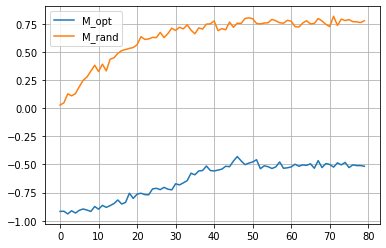

In [14]:
#if only one run
plt.plot(range(len(M_opt)),M_opt,label='M_opt')
plt.plot(range(len(M_rand)),M_rand,label='M_rand')
plt.legend()
plt.grid()

print('X wins',res.count('X')/len(res))
print('O wins',res.count('O')/len(res))
print('Draws',res.count(None)/len(res))

(-1.0, 1.0)

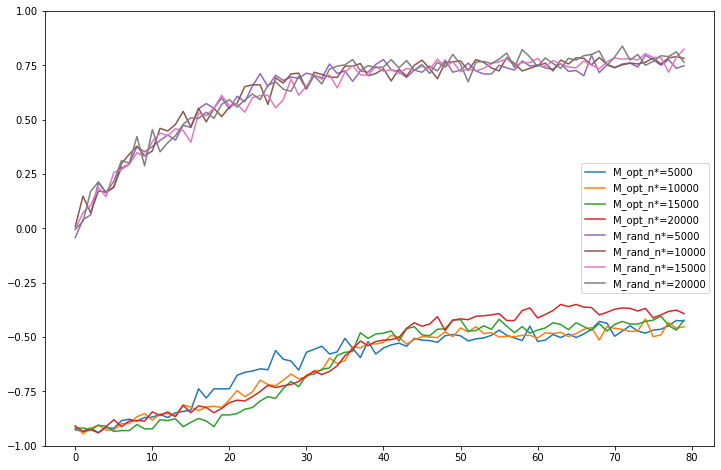

In [10]:
#if multiple runs
plt.figure(figsize=(12,8))
for eps in M_opts.columns:
    plt.plot(range(len(M_opts)),M_opts[eps],label='M_opt_n*='+str(eps))
for eps in M_opts.columns:
    plt.plot(range(len(M_opts)),M_rands[eps],label='M_rand_n*='+str(eps))
plt.legend()
plt.ylim(-1,1)

In [33]:
print(np.count_nonzero(Q_table),3**9-np.count_nonzero(Q_table))

9040 10643


[[-1  1 -1]
 [ 1  1 -1]
 [ 0 -1  0]]


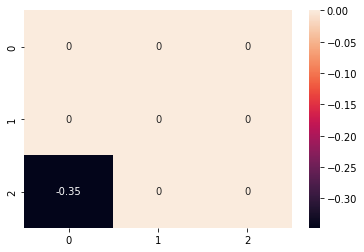

In [32]:
#to check the Q-vals from a given state
board=[-1,1,-0,0,0,0,0,0,0]
sns.heatmap(Q_table[boards.index(board)].reshape(3,3),annot=True)
print(np.array(boards[boards.index(board)]).reshape(3,3))

In [426]:
len([])


0